#### This code reads packetloss data for one site and runs anomaly detection on it.

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from sklearn import tree

from sklearn.metrics import roc_curve, auc

from pandas.tseries.offsets import *

from graphviz import Source

#### parameters to set

In [2]:
n_series = 10
start_date = '2017-08-01 00:00:00'
end_date = '2017-08-07 23:59:59'

# tuning parameters
cut = 0.9
window = 24


# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS='CERN-PROD'
srcSiteOWDServer = "128.142.223.247"
#srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS='pic'
destSiteOWDServer = "193.109.172.188"
#destSiteThroughputServer = "193.109.172.187"


## get data from ES

In [3]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.8.*"

start = pd.Timestamp(start_date)
end   = pd.Timestamp(end_date)

my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': start.strftime('%Y%m%dT%H%M00Z'), 'lt': end.strftime('%Y%m%dT%H%M00Z')}}},
                    {'bool':
                        {'should':[
                            {'term': {'src': srcSiteOWDServer}},
                            #{'term': {'src': srcSiteThroughputServer}},
                            #{'term': {'src': destSiteOWDServer}},
                            #{'term': {'src': destSiteThroughputServer}}
                        ]}
                    },
#                     {'bool':
#                         {'should':[
#                             {'term': {'dest': destSiteOWDServer}},
#                             #{'term': {'dest': destSiteThroughputServer}},
#                             #{'term': {'dest': srcSiteOWDServer}},
#                             #{'term': {'dest': srcSiteThroughputServer}}
#                         ]}
#                     },
                    {'bool':
                        {'should':[
                            {'term': {'_type': 'packet_loss_rate'}},
                            #{'term': {'_type': 'latency'}},
                            #{'term': {'_type': ''}},
                            #{'term': {'_type': ''}}
                        ]}
                    }
                
                   ]
            }
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))

### scan the data

In [4]:
count = 0
allData={} # will be like this: {'dest_host':[[timestamp],[value]], ...} 
for res in scroll:
#     if count<2: print(res)
    if not count%100000: print(count)
    if count>1000000: break
    dst = res['_source']['dest_host']
    if dst not in allData: allData[dst]=[[],[]]
    allData[dst][0].append(res['_source']['timestamp'] )
    allData[dst][1].append(res['_source']['packet_loss'])
    
    count=count+1

dfs=[]
for dest,data in allData.items():
    ts=pd.to_datetime(data[0],unit='ms')
    df=pd.DataFrame({dest:data[1]}, index=ts )
    df.sort_index(inplace=True)
    df.index = df.index.map(lambda t: t.replace(second=0))
    df = df[~df.index.duplicated(keep='last')]
    dfs.append(df)
    #print(df.head(2))

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


In [5]:
full_df = pd.concat(dfs, axis=1)

In [6]:
print(full_df.shape)
# full_df.head()
print(full_df.columns )

(9850, 86)
Index(['t2ps-latency.physics.ox.ac.uk', 'ps-01.lnl.infn.it',
       'btw-lat.grid.kiae.ru', 'perfsonar2.ihep.ac.cn', 'lpnhe-psl.in2p3.fr',
       'tech-ps.hep.technion.ac.il', 'llrpsonar1.in2p3.fr', 'perfs-wigner-lt',
       'ps-gsdc01.sdfarm.kr', 'perfsonar-lt.tier2.hep.manchester.ac.uk',
       'psl.hpc.utfsm.cl', 'psbud01.kfki.hu', 'ps-latency.sfu.westgrid.ca',
       'perfsonar01.lcg.cscs.ch', 'hcc-ps01.unl.edu',
       'lcgps01.gridpp.rl.ac.uk', 'ps-latency.lhcmon.triumf.ca',
       'pygrid-sonar2.lancs.ac.uk', 'lhcperfmon.bnl.gov',
       'perfsonar01.cmsaf.mit.edu', '18.12.1.171', 'lhc-latency.twgrid.org',
       'psonar4.fnal.gov', 'btw-lat.t1.grid.kiae.ru',
       'perfsonar-ps-latency.igfae.usc.es', 'ps01-l.farm.particle.cz',
       'perfsonar2.roma1.infn.it', 'psonartest2.fnal.gov',
       'perfsonar2-de-kit.gridka.de', 'gridpp-ps-lat.ecdf.ed.ac.uk',
       'perfsonar-2.t2.ucsd.edu', 'ps1.kipt.kharkov.ua', 't1-pfsn2.jinr-t1.ru',
       '212.193.96.29', 'heplnx129.

#### plot timeseries

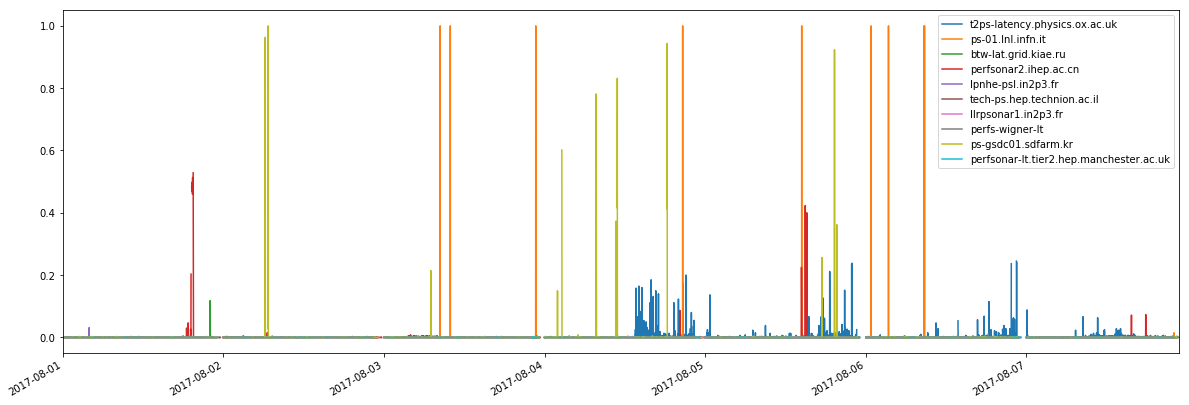

In [7]:
full_df.iloc[:,0:n_series].plot(figsize=(20,7))

#### functions

In [8]:
def check_for_anomaly(ref, sub):
    
    y_ref = pd.Series([0] * ref.shape[0])
    X_ref = ref
    del X_ref['auc_score']
    
    y_sub = pd.Series([1] * sub.shape[0])
    X_sub=sub
    del X_sub['auc_score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
#     dtc=DecisionTreeClassifier()
    clf = AdaBoostClassifier() #dtc
#     clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=200)
    
    #train an AdaBoost model to be able to tell the difference between the reference and subject data
    clf.fit(X_train, y_train) 

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    
    # scores = cross_val_score(clf, X, y)
    # print(scores)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    print ("auc_score = ", auc_score, "\tfeature importances:", clf.feature_importances_)
    
    if auc_score > cut: 
        plot_roc(fpr, tpr, auc_score)
#         filename='tree_'+sub.index.min().strftime("%Y-%m-%d_%H")
#         tree.export_graphviz(clf.estimators_[0] , out_file=filename +'_1.dot') 
#         tree.export_graphviz(clf.estimators_[1] , out_file=filename +'_2.dot') 
        
    return auc_score

In [9]:
def plot_roc(fpr,tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], linestyle='--', color='r',label='Luck', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### select part of the data. fix NANs

In [10]:
df = full_df.iloc[:,n_series]
df = df.interpolate(method='time', axis=0)

#### Looping over time intervals

In [11]:
df['auc_score']=0.5
#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0

ref = window * Hour()
sub = 1 * Hour()

# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    auc_score = check_for_anomaly(ref_df, sub_df)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['auc_score']] = auc_score
    print(ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tauc:', auc_score)
    ti = ti + sub
    count=count+1
    #if count>2: break
    


TypeError: Cannot compare type 'Timestamp' with type 'str'

In [ ]:
df.plot(figsize=(20,7))


In [ ]:
fig, ax = plt.subplots(figsize=(20,7))
df.loc[:,'Detected'] = 0
df.loc[df.auc_score>cut,'Detected']=1
df.head()
# ax.plot(df.Flag, 'r')
ax.plot(df.auc_score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()